# Assignment 2

For this assignment, I opted to use python for the following data analysis, allowing for a more robust and flexible approach. There is a multitude of different species of trees in our collection, and due to the nature of allometry and availability of certain species, I have chosen to primarily focus on the species which either have the largest number of trees and which have a high DBH. 

In [1]:
## IMPORTS ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(r"C:\Users\perso\Desktop\Tulane U\Senior Year\Semester 7\EENS-4081\Assignment 2\Carbon stock and sequestration assessment-SISON.csv", header= 2)
data.head(5)

,Group members,Tree #,Species,Diameter (cm),Condition\n Excellent/good/fair/poor/dead,Sunlight\n Full sun/partial sun/full shade,Other notes
0,Mikey/Rayna,1,Crape Myrtle,57.4,good,partial sun,NaN
1,Mikey/Rayna,2,Green Ash,90.2,excellent,full sun,NaN
2,Mikey/Rayna,3,Cyprus,44.3,excellent,partial sun,NaN
3,Mikey/Rayna,4,Cyprus,50.4,excellent,full sun,NaN
4,Mikey/Rayna,5,Cyprus,55.1,good,partial sun,NaN


## Consolidated Species 

Since, due to human intervention, there are many species names that are not uniform in text format. Thus, we can do a simple comparison to reformat each species to the correct format. This allows us to group and compare species much better than previously. 

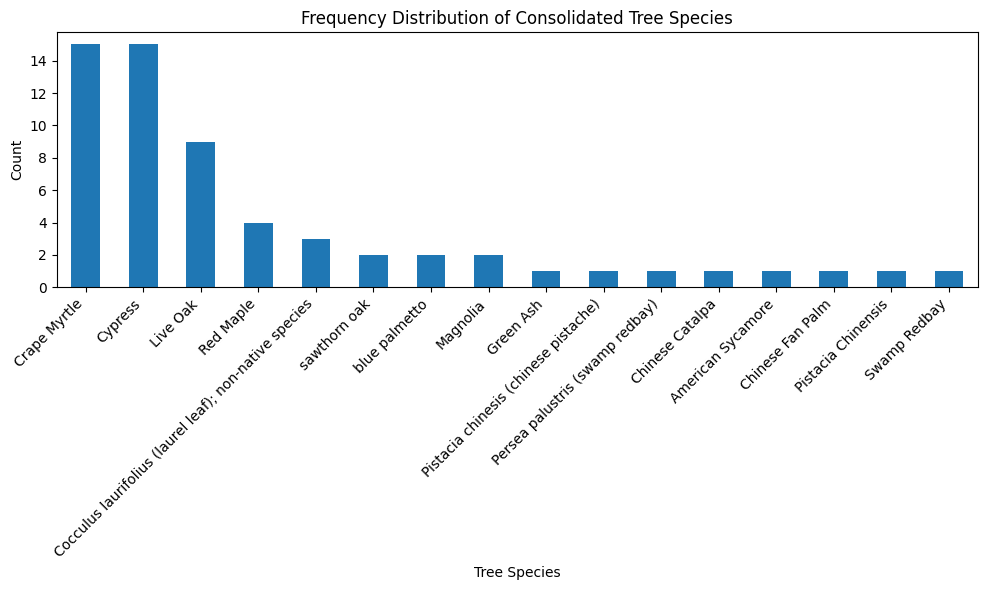

In [2]:
consolidated_data = data

# Unify the text formatting for species names.
consolidated_data['Species'] = data['Species'].str.replace('cyprus', 'cypress', case=False)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Cypress' if 'cypress' in x.lower() else x)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Live Oak' if 'live oak' in x.lower() else x)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Magnolia' if 'magnolia' in x.lower() else x)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Crape Myrtle' if 'crape myrtle' in x.lower() else x)
consolidated_data['Species'] = data['Species'].apply(lambda x: 'Red Maple' if 'red maple' in x.lower() else x)


# Counting the frequency of each consolidated tree species
consolidated_species_counts = data['Species'].value_counts()

# Plotting the frequency of each consolidated species
plt.figure(figsize=(10, 6))
consolidated_species_counts.plot(kind='bar')
plt.title('Frequency Distribution of Consolidated Tree Species')
plt.xlabel('Tree Species')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [4]:
species_to_drop = [
    "blue palmetto",    
    'Magnolia',
    "American Sycamore", 
    "Chinese Catalpa", 
    "Chinese Fan Palm", 
    "Swamp Redbay", 
    "Cocculus laurifolius (laurel leaf); non-native species",
    "Pistacia chinesis (chinese pistache)",
    "Persea palustris (swamp redbay)",
    "Pistacia Chinensis",
    np.nan
    ]

indices_to_drop = consolidated_data[
    (consolidated_data['Species'].str.contains('blue palmetto', case=False)) | 
    (consolidated_data['Species'].str.contains('Magnolia', case=False)) | 
    (consolidated_data['Species'].str.contains("sawthorn oak", case=False))

].index



# Filter the data again to exclude the final list of species
consolidated_data = consolidated_data[~consolidated_data['Species'].isin(species_to_drop)]
consolidated_data = consolidated_data.drop(indices_to_drop)

remaining_species_adjusted = consolidated_data['Species'].unique()
remaining_species_adjusted

array(['Crape Myrtle', 'Green Ash', 'Cypress', 'Live Oak', 'Red Maple'],
      dtype=object)

In [5]:
# Convert the 'Diameter (cm)' column to a numeric type
consolidated_data['Diameter (cm)'] = pd.to_numeric(data['Diameter (cm)'], errors='coerce')

# Convert the 'Diameter (cm)' to inches for ITree 
consolidated_data['Diameter (in)'] = consolidated_data['Diameter (cm)'] * 0.393701

# Grouping by species and calculating the average diameter
species_diameter_avg = consolidated_data.groupby('Species')['Diameter (cm)'].mean().sort_values(ascending=False)

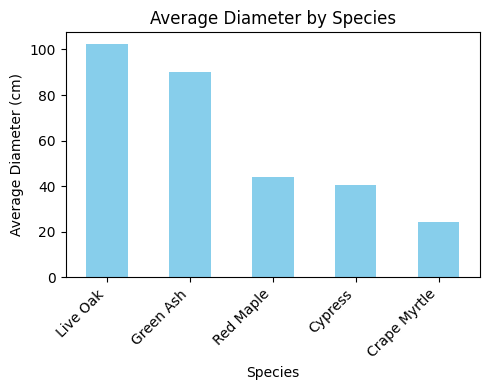

In [6]:
# Plotting the average diameter by species
plt.figure(figsize=(5, 4))
species_diameter_avg.plot(kind='bar', color='skyblue')
plt.title('Average Diameter by Species')
plt.xlabel('Species')
plt.ylabel('Average Diameter (cm)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Allometry 

 As described by Jenkins et al. (2004), there exist many different allometric equations for the estimation of dry biomass. However, for certain species, there are limitations on accurate estimation due to a number of factors. Constraints on the DBH range, availablility of species equations, and uncertainties are all cited as important factors. For the purposes of this analysis, some assumptions or liberties have been made in order to ensure plausible calculations. 


Jenkins et al. (2004) Equations for the estimation of dry biomass

General: biomass = exp(Beta0 + Beta1*ln(dbh))
1. log10 biomass = a + b * (log10(dia^c)) 
2. ln biomass = a + b * dia + c * (ln(dia^d)) 
3. ln biomass = a + b * ln(dia) + c * (d + (e * ln(dia))) 
4. biomass = a + b * dia + c * (dia ^ d) 
5. biomass = a + (b * dia) + c * (dia ^ 2) + d * (dia ^ 3) 
6. biomass = a * (exp(b + (c * ln(dia)) + (d * dia))) 
7. biomass = a + ((b * (dia ^ c))/((dia ^ c) + d)) 
8. log100 biomass = a + (b * log10(dia)) 
9. ln biomass = ln(a) + (b * ln(dia)) 

Boerner & Kost Equation:
ln(biomass) = a + b(ln dbh),

In [7]:
# Set & create Biomass column
consolidated_data["Carbon Stock (Kg) General"] = np.nan
consolidated_data["Carbon Stock (Kg) eq1"] = np.nan
consolidated_data["Carbon Stock (Kg) eq2"] = np.nan
consolidated_data["Carbon Stock (Kg) eq3"] = np.nan
consolidated_data["Carbon Stock (Kg) eq4"] = np.nan
consolidated_data["Carbon Stock (Kg) eq5"] = np.nan
consolidated_data["Carbon Stock (Kg) eq6"] = np.nan
consolidated_data["Carbon Stock (Kg) eq7"] = np.nan
consolidated_data["Carbon Stock (Kg) eq8"] = np.nan
consolidated_data["Carbon Stock (Kg) eq9"] = np.nan
consolidated_data["Carbon Stock (Kg) BK_eq"] = np.nan


In [8]:
# Allometric equations
import math

allometric_equations = { 
                         "eq1" : lambda dbh, a, b, c:       (10**(a + b*(math.log10(dbh**c)))) / 2,
                         "eq2" : lambda dbh, a, b, c, d:    (math.exp(a + b*dbh + c*(math.log(dbh**d))))/2,
                         "eq3" : lambda dbh, a, b, c, d, e: (math.exp(a + b*math.log(dbh) + c*(d + e*math.log(dbh)))) / 2,
                         "eq4" : lambda dbh, a, b, c, d:    (a + b*dbh + c*(dbh**d)) / 2,
                         "eq5" : lambda dbh, a, b, c, d:    (a + b*dbh + c*(dbh**2) + d*(dbh**3) ) / 2,
                         "eq6" : lambda dbh, a, b, c:       (a*(math.exp(b+(c*math.log())))) / 2,
                         "eq7" : lambda dbh, a, b, c, d:    (a+((b*(dbh**c))/(dbh**c)+d)) / 2,
                         "eq8" : lambda dbh, a, b:          (100**(a + (b * math.log10(dbh)))) / 2,
                         "eq9" : lambda dbh, a, b, :        (math.exp(math.log(a) + (b*math.log(dbh)))) / 2,
                         "general" : lambda dbh, beta0, beta1: (math.exp(beta0 + beta1*math.log(dbh))) / 2,
                         "BK_eq" : lambda dbh, a, b:        (math.exp(a + b*(math.log(dbh)))) / 2,
                        }
# Notes: math.log is ln. math.log10 is log base 10. math.exp is e^x.

### Live Oak Allometry Model

As described by Jenkins et al. (2004) and independent database and Google Scholar search results, there does not exist exact allometric equations for, specifically, Live Oaks, *Quercus virginiana*. Jenkins et al. (2004) does describe a methodology for estimating species without exact allometric equations. They specifically mention Live Oaks as one of these species. Unfortunately, the DBH range for the general equation provided with hardwoods parameters is lower than most of the Live Oak DBH measurements that we obtained. However, the paper does specify the Northern Red Oak as the sourcee for bark specific gravity estimations for the *genus Quercus*. So, for this and further estimates, I will use the reference species as a secondary plausible estimate for biomass. So, both the general equation for hardwoods will be used, as well as the specific equation for the Northern Red Oak.

#### General Hardwood Estimation

In [9]:
# General Equation
beta0_LO = -2.0127
beta1_LO = 2.4342
liveOaks = consolidated_data[consolidated_data["Species"] == "Live Oak"]
consolidated_data.loc[consolidated_data["Species"] == "Live Oak","Carbon Stock (Kg) General"] = liveOaks["Diameter (cm)"].apply(allometric_equations["general"], args=(beta0_LO, beta1_LO))


#### Northern Red Oak Estimation (Jenkins et al., #833)

Using the Northern Red Oak Estimation for the whole aboveground biomass, we can use equations 1 and 2. Again, similar to the general equation, our DBH measurements are outside of the range specified. Each of these equations had R^2 values of 0.99, highlighting the effectiveness of these more specific equations.

In [10]:
# Equation 1
a = -1.259		
b = 2.644
c = 1

consolidated_data.loc[consolidated_data["Species"] == "Live Oak","Carbon Stock (Kg) eq1"] = liveOaks["Diameter (cm)"].apply(allometric_equations["eq1"], args=(a, b, c))


In [11]:
# Equation 2 
a = 4.9967
b = 0
c = 2.3944
d = 1

consolidated_data.loc[consolidated_data["Species"] == "Live Oak","Carbon Stock (Kg) eq2"] = liveOaks["Diameter (cm)"].apply(allometric_equations["eq2"], args=(a, b, c, d)) / 1000
consolidated_data[consolidated_data["Species"] == "Live Oak"].head(5)

,Group members,Tree #,Species,Diameter (cm),Condition\n Excellent/good/fair/poor/dead,Sunlight\n Full sun/partial sun/full shade,Other notes,Diameter (in),Carbon Stock (Kg) General,Carbon Stock (Kg) eq1,Carbon Stock (Kg) eq2,Carbon Stock (Kg) eq3,Carbon Stock (Kg) eq4,Carbon Stock (Kg) eq5,Carbon Stock (Kg) eq6,Carbon Stock (Kg) eq7,Carbon Stock (Kg) eq8,Carbon Stock (Kg) eq9,Carbon Stock (Kg) BK_eq
12,Mikey/Rayna,13,Live Oak,112.1,excellent,full sun,NaN,44.133882,6516.516253,7229.815991,5978.399334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Zoë/Guandong,20,Live Oak,69.9,Excellent,Full sun,NaN,27.519700,2063.915164,2073.803757,1929.413850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Zoë/Guandong,21,Live Oak,41.4,Excellent,Full sun,NaN,16.299221,576.723610,519.181138,550.496876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Zoë/Guandong,22,Live Oak,119.8,Excellent,Full sun,NaN,47.165380,7660.287810,8618.066308,7009.164412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,Melinda/Asif,28,Live Oak,151.5,Fair,Partial sun,NaN,59.645702,13565.191574,16031.752722,12296.719037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Bald Cypress Allometry Model
Similar to the Live Oak, the Bald Cypress does not have species specific equations. Instead, we can use the generalized equations for softwoods with Cedars & Larch parameters. We also will use the reference species, the Northern White Cedar. 

In [12]:
# General Equation
beta0 = -2.0336 
beta1 = 2.2592
baldCypress = consolidated_data[consolidated_data["Species"] == "Cypress"]
consolidated_data.loc[consolidated_data["Species"] == "Cypress","Carbon Stock (Kg) General"] = baldCypress["Diameter (cm)"].apply(allometric_equations["general"], args=(beta0, beta1))


#### Northern White Cedar Estimation (Jenkins et al., #241)
The equation provided is only applicable up to 30cm, explaining some of the larger differences at the higher end of the DBH range (see Appendix 1).

In [13]:
# Equation 4
a, b, c, d = 0,	0,	0.1148,	2.1439

consolidated_data.loc[consolidated_data["Species"] == "Cypress","Carbon Stock (Kg) eq4"] = baldCypress["Diameter (cm)"].apply(allometric_equations["eq4"], args=(a, b, c, d))


### Green Ash
Ash falls into the category of "Mixed Hardwood" for the general calculations. The Green Ash also can be estimated using the allometric equations from the White Ash, as described by Jenkins et al. (2004).

In [14]:
# General Equation
beta0 = -2.4800 
beta1 = 2.4835
greenAsh = consolidated_data[consolidated_data["Species"] == "Green Ash"]
consolidated_data.loc[consolidated_data["Species"] == "Green Ash","Carbon Stock (Kg) General"] = greenAsh["Diameter (cm)"].apply(allometric_equations["general"], args=(beta0, beta1))

#### White Ash Estimation (Jenkins et al., #541)


In [15]:
# Equation 1
a, b, c = 1.2784, 1.4248, 2

consolidated_data.loc[consolidated_data["Species"] == "Green Ash","Carbon Stock (Kg) eq1"] = greenAsh["Diameter (cm)"].apply(allometric_equations["eq1"], args=(a, b, c))/1000
consolidated_data[consolidated_data["Species"] == "Green Ash"].head(5)

,Group members,Tree #,Species,Diameter (cm),Condition\n Excellent/good/fair/poor/dead,Sunlight\n Full sun/partial sun/full shade,Other notes,Diameter (in),Carbon Stock (Kg) General,Carbon Stock (Kg) eq1,Carbon Stock (Kg) eq2,Carbon Stock (Kg) eq3,Carbon Stock (Kg) eq4,Carbon Stock (Kg) eq5,Carbon Stock (Kg) eq6,Carbon Stock (Kg) eq7,Carbon Stock (Kg) eq8,Carbon Stock (Kg) eq9,Carbon Stock (Kg) BK_eq
1,Mikey/Rayna,2,Green Ash,90.2,excellent,full sun,NaN,35.51183,3003.828442,3539.374794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Red Maple (Jenkins et al., #316)
The Red Maple is considered a "soft maple/birch". There exist multiple allometric equations for the Red Maple, where preference was given to the equations which have the highest DBH range.

In [16]:
# General Equation
beta0 = -1.9123
beta1 =  2.3651
redMaple = consolidated_data[consolidated_data["Species"] == "Red Maple"]
consolidated_data.loc[consolidated_data["Species"] == "Red Maple","Carbon Stock (Kg) General"] = redMaple["Diameter (cm)"].apply(allometric_equations["general"], args=(beta0, beta1))

In [17]:
# Equation 1
a, b, c = -1.06, 2.574,	1

redMaple = consolidated_data[consolidated_data["Species"] == "Red Maple"]
consolidated_data.loc[consolidated_data["Species"] == "Red Maple","Carbon Stock (Kg) eq1"] = redMaple["Diameter (cm)"].apply(allometric_equations["eq1"], args=(a,b,c))

In [18]:
# Equation 2
a, b, c, d = -1.721, 0,	2.334,	1

consolidated_data.loc[consolidated_data["Species"] == "Red Maple","Carbon Stock (Kg) eq2"] = redMaple["Diameter (cm)"].apply(allometric_equations["eq2"], args=(a,b,c,d))

### Crape Myrtle Allometric Model
There exists a deficit in research and information surrounding estimating the biomass of Crape Myrtle, *Lagerstroemia*, species. Due to this fact, I decided to make some educated assumptions about the biomass estimations of Crape Myrtles. First, I opted to use the Flowering Dogwood, *Cornus florida*, as a possible model for the Crape Myrtle due to several shared characteristics. Both are flowering plants which showcase vibrant blooms during their flowering seasons. They also share similar sizes and growth forms, often being categorized as small trees or large shrubs. Moreover, they thrive in similar temperate climate conditions, which might mean they share similar biomass allocation patterns (Boerner & Kost, 1986). From Boerner & Kost (1986), we can use the parameters for the Flowering Dogwood, which uses biomass = exp(a + b(ln dbh)).

Also, in my deliberations, Willow was considered as a candidate for Crape Myrtle. As a result, I will use the general equation with the "Hardwood, Willow" parameter from Jenkins et al. (2004) as well.

In [19]:
# General Equation
beta0 = -2.2094
beta1 =   2.3867
crapeMyrtle = consolidated_data[consolidated_data["Species"] == "Crape Myrtle"]
consolidated_data.loc[consolidated_data["Species"] == "Crape Myrtle","Carbon Stock (Kg) General"] = crapeMyrtle["Diameter (cm)"].apply(allometric_equations["general"], args=(beta0, beta1))

In [20]:
# Boerner & Kost Equation 
a, b = 5.67, 1.97

consolidated_data.loc[consolidated_data["Species"] == "Crape Myrtle","Carbon Stock (Kg) BK_eq"] = crapeMyrtle["Diameter (cm)"].apply(allometric_equations["BK_eq"], args=(a, b))/1000

In [21]:
consolidated_data

,Group members,Tree #,Species,Diameter (cm),Condition\n Excellent/good/fair/poor/dead,Sunlight\n Full sun/partial sun/full shade,Other notes,Diameter (in),Carbon Stock (Kg) General,Carbon Stock (Kg) eq1,Carbon Stock (Kg) eq2,Carbon Stock (Kg) eq3,Carbon Stock (Kg) eq4,Carbon Stock (Kg) eq5,Carbon Stock (Kg) eq6,Carbon Stock (Kg) eq7,Carbon Stock (Kg) eq8,Carbon Stock (Kg) eq9,Carbon Stock (Kg) BK_eq
0,Mikey/Rayna,1,Crape Myrtle,57.4,good,partial sun,NaN,22.598437,865.834306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,423.132267
1,Mikey/Rayna,2,Green Ash,90.2,excellent,full sun,NaN,35.511830,3003.828442,3539.374794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mikey/Rayna,3,Cypress,44.3,excellent,partial sun,NaN,17.440954,343.039432,NaN,NaN,NaN,194.373404,NaN,NaN,NaN,NaN,NaN,NaN
3,Mikey/Rayna,4,Cypress,50.4,excellent,full sun,NaN,19.842530,459.113236,NaN,NaN,NaN,256.302427,NaN,NaN,NaN,NaN,NaN,NaN
4,Mikey/Rayna,5,Cypress,55.1,good,partial sun,NaN,21.692925,561.562939,NaN,NaN,NaN,310.289304,NaN,NaN,NaN,NaN,NaN,NaN
5,Mikey/Rayna,6,Cypress,4.9,excellent,full sun,NaN,1.929135,2.371809,NaN,NaN,NaN,1.732301,NaN,NaN,NaN,NaN,NaN,NaN
6,Mikey/Rayna,7,Crape Myrtle,20.3,good,full sun,NaN,7.992130,72.450364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.599279
7,Mikey/Rayna,8,Crape Myrtle,63.8,good,full sun,NaN,25.118124,1114.308106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,521.094457
12,Mikey/Rayna,13,Live Oak,112.1,excellent,full sun,NaN,44.133882,6516.516253,7229.815991,5978.399334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Zoë/Guandong,14,Crape Myrtle,20.1,Fair,Partial sun,NaN,7.913390,70.758368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.544633


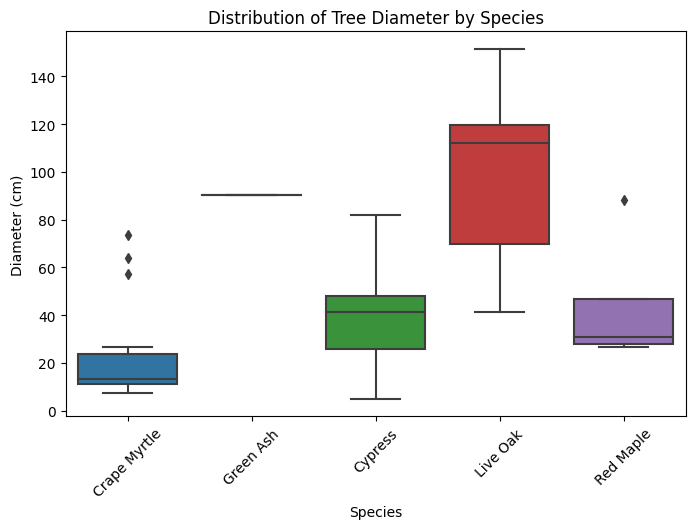

In [22]:
# Plot the diameter distribution by species for the filtered data
plt.figure(figsize=(8, 5))
sns.boxplot(x="Species", y="Diameter (cm)", data=consolidated_data)
plt.xticks(rotation=45)
plt.title("Distribution of Tree Diameter by Species")
plt.ylabel("Diameter (cm)")
plt.xlabel("Species")
plt.show()

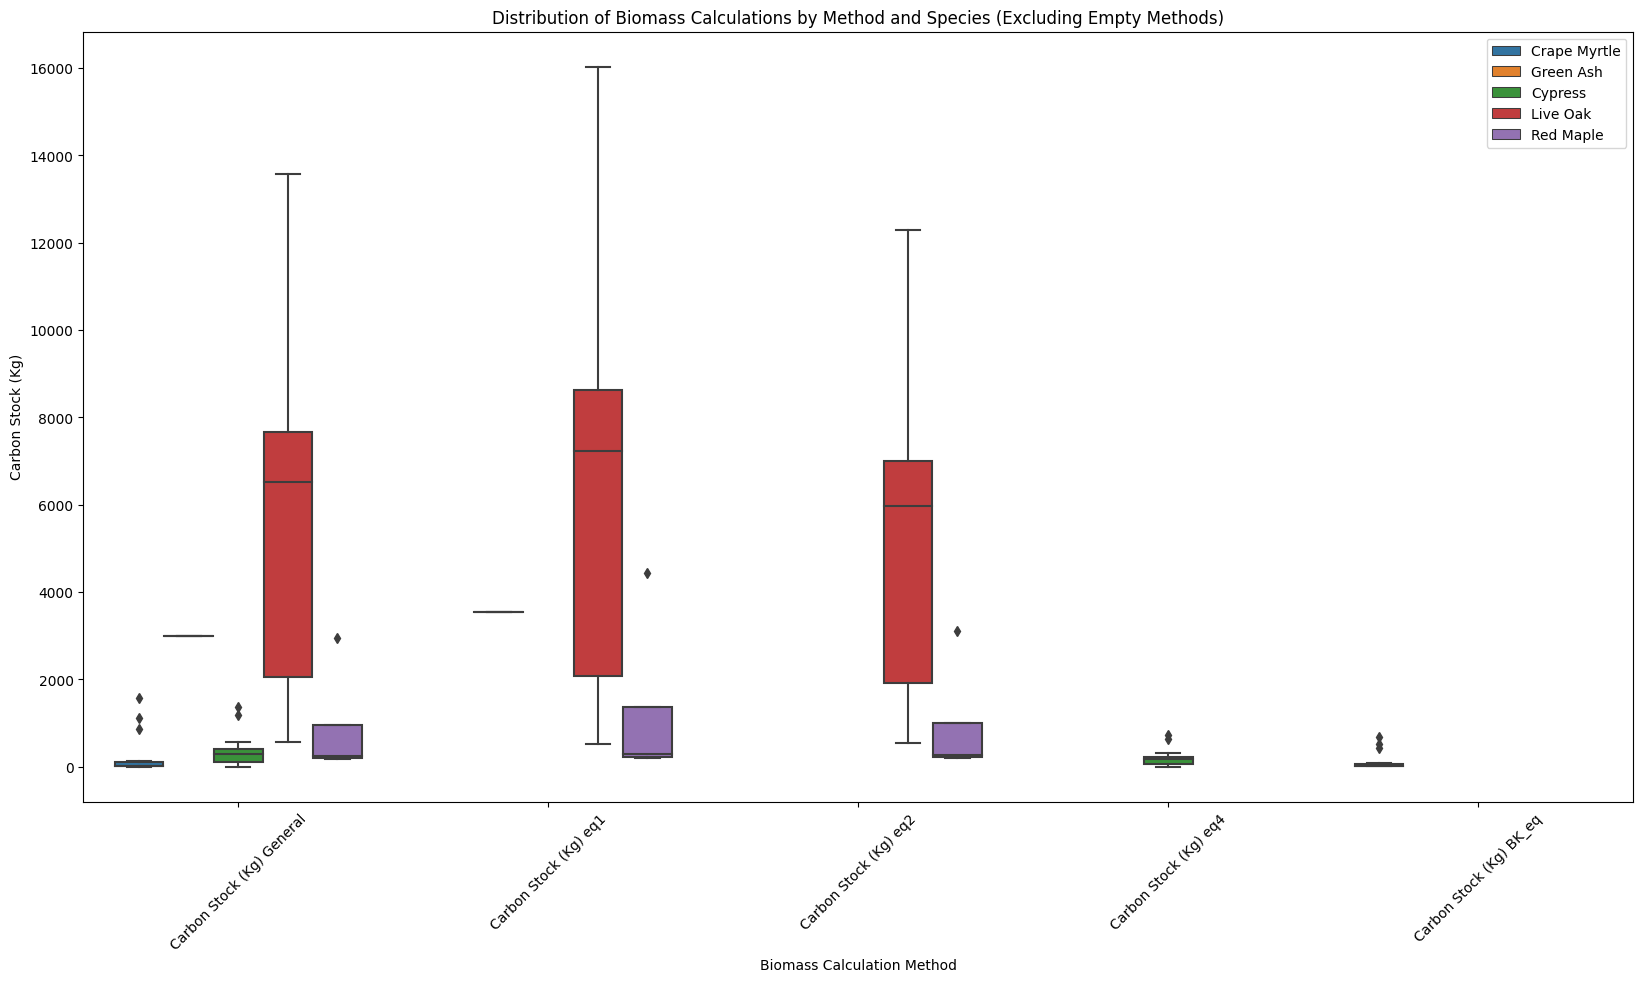

In [23]:
# Identify columns that have no data
biomass_columns = ['Carbon Stock (Kg) General',
 'Carbon Stock (Kg) eq1',
 'Carbon Stock (Kg) eq2',
 'Carbon Stock (Kg) eq3',
 'Carbon Stock (Kg) eq4',
 'Carbon Stock (Kg) eq5',
 'Carbon Stock (Kg) eq6',
 'Carbon Stock (Kg) eq7',
 'Carbon Stock (Kg) eq8',
 'Carbon Stock (Kg) eq9',
 'Carbon Stock (Kg) BK_eq']

columns_with_data = consolidated_data[biomass_columns].dropna(axis=1, how='all').columns

# Melt the filtered data with only the columns that have data
biomass_melted_with_data = consolidated_data.melt(id_vars=["Tree #", "Species"], 
                                                            value_vars=columns_with_data, 
                                                            var_name="Method", value_name="Carbon Stock (Kg)")

# Plot the data with species differentiation
plt.figure(figsize=(20, 10))
sns.boxplot(x="Method", y="Carbon Stock (Kg)", hue="Species", data=biomass_melted_with_data)
plt.xticks(rotation=90)
plt.title("Distribution of Biomass Calculations by Method and Species (Excluding Empty Methods)")
plt.ylabel("Carbon Stock (Kg)")
plt.xlabel("Biomass Calculation Method")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


Within a given method, there is a clear variability in biomass calculations across different species, highlighting the variability in growth patterns and biomass densities. Some species show noticeable outliers in certain biomass calculation methods, indicating trees that have biomass values significantly different from the majority of trees of the same species calculated using the same method. Particularly in the case of the Crape Myrtle, for some of the outliers, I hypothesize that some of the DBH measurements might have been taken around multiple trunks.

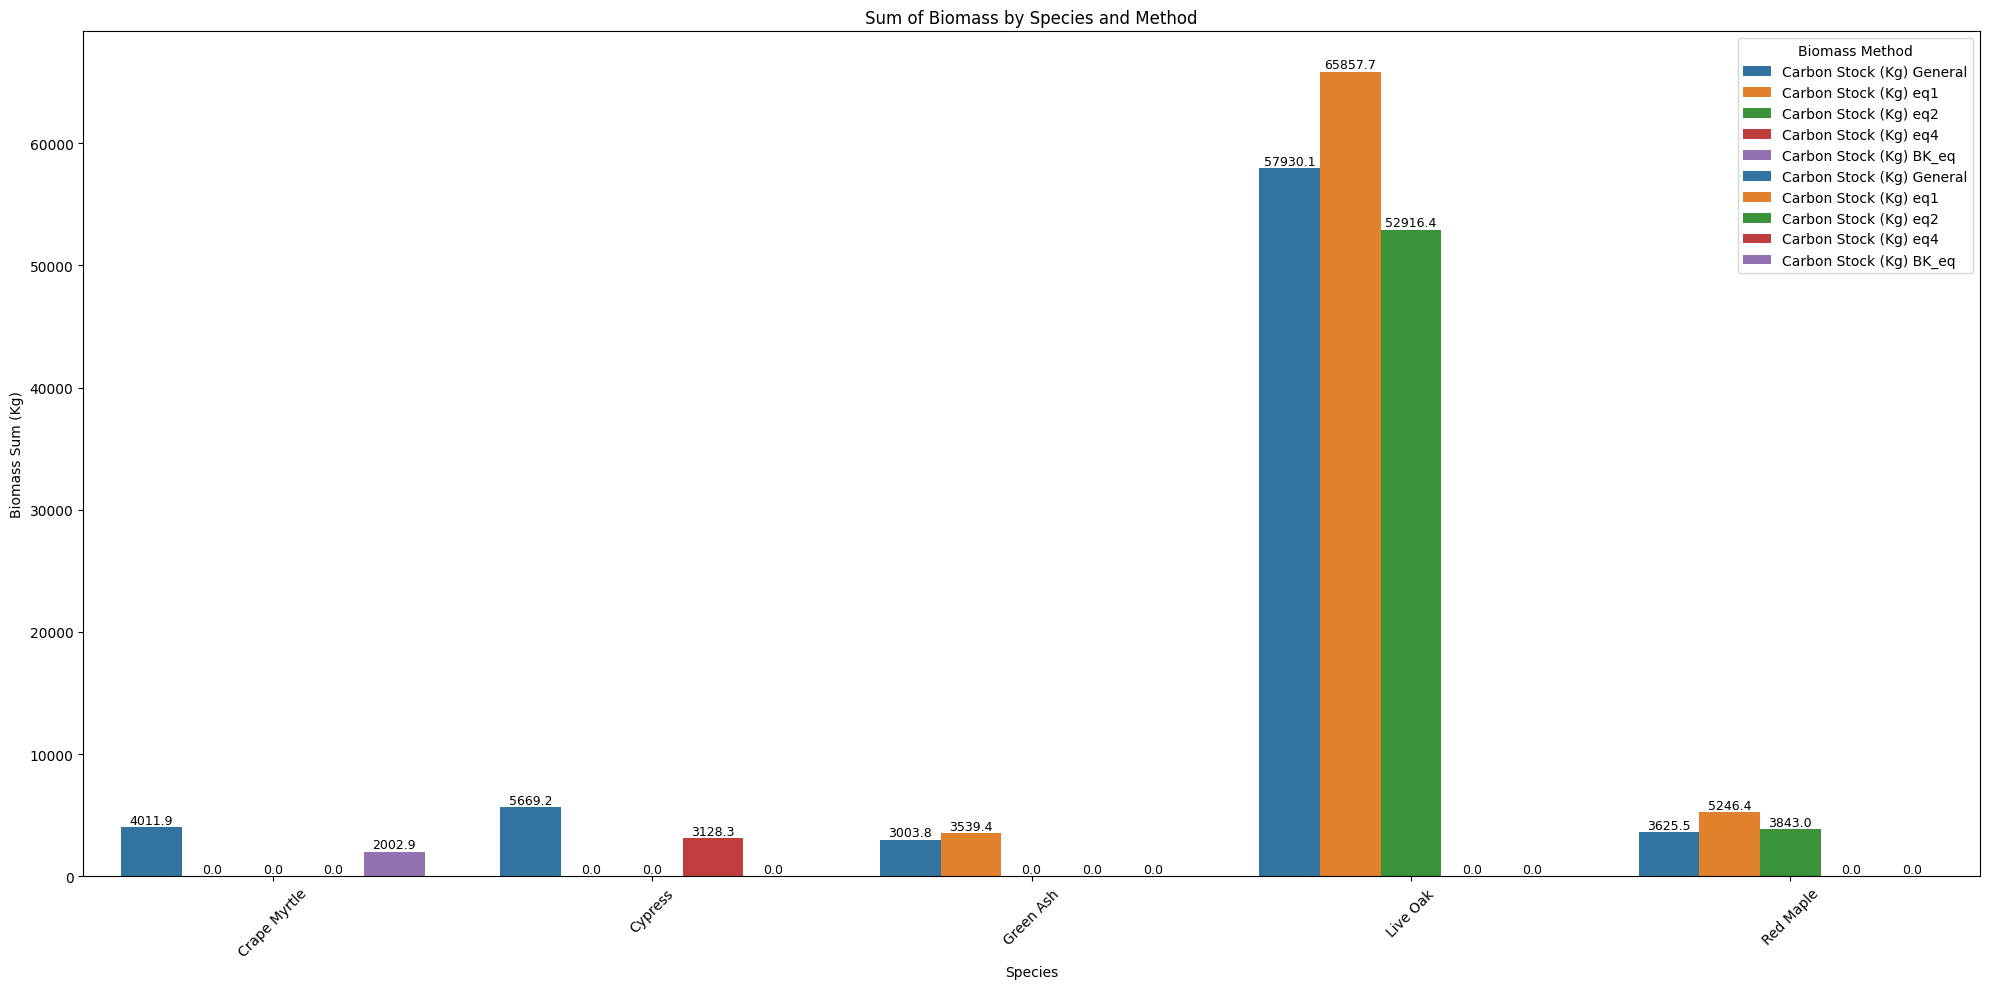

In [32]:
# Calculate the sum of biomass by species for each method and melt the data
biomass_sum_by_species = consolidated_data.groupby('Species')[columns_with_data].sum().reset_index()
biomass_sum_melted = biomass_sum_by_species.melt(id_vars=["Species"], value_vars=columns_with_data, 
                                                 var_name="Method", value_name="Biomass Sum (Kg)")

plt.figure(figsize=(20, 10))
ax = sns.barplot(x="Species", y="Biomass Sum (Kg)", hue="Method", data=biomass_sum_melted)

# Adding numerical callouts to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=9, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')


sns.barplot(x="Species", y="Biomass Sum (Kg)", hue="Method", data=biomass_sum_melted, )
plt.xticks(rotation=45)
plt.title("Sum of Biomass by Species and Method")
plt.ylabel("Biomass Sum (Kg)")
plt.xlabel("Species")
plt.legend(loc='upper right', title="Biomass Method")
plt.tight_layout()
plt.show()

Logically, the Live Oak contains the greatest amount of biomass Carbon. Surprisingly however, despite the number of Cypress and Crape Myrtles, the Live Oak still massively outclasses the others.

In [36]:
overall_biomass_sum_with_data = consolidated_data[columns_with_data].sum()

kg_to_lbs = 2.20462

overall_biomass_sum_df = overall_biomass_sum_with_data.reset_index()
overall_biomass_sum_df.columns = ["Method", "Carbon Stock Sum (Kg)"]

# Add a new column for biomass sum in lbs
overall_biomass_sum_df["Carbon Stock Sum (lbs)"] = overall_biomass_sum_df["Carbon Stock Sum (Kg)"] * kg_to_lbs
overall_biomass_sum_df

,Method,Carbon Stock Sum (Kg),Carbon Stock Sum (lbs)
0,Carbon Stock (Kg) General,74240.619271,163672.354058
1,Carbon Stock (Kg) eq1,74643.486279,164560.522720
2,Carbon Stock (Kg) eq2,56759.333003,125132.760725
3,Carbon Stock (Kg) eq4,3128.339135,6896.799023
4,Carbon Stock (Kg) BK_eq,2002.910358,4415.656234


Surprisingly, the general method of calculating carbon stocks and the more specialized equation 1 ended up being fairly similar. The only difference between the two can be attributed to the fact that the Bald Cypress did not have parameters associated with equation 1.

## ITree analysis

<div style="display: flex; justify-content: space-between;">
    <img src="docs\assets\cc.png" alt="ITree Yearly Estimates" style="width: 45%; margin-right: 5%;">
    <img src="docs\assets\cc2.png" alt="ITree 20-Year Estimmate" style="width: 45%;">
</div>





Interestingly, the ITree analysis underscores the carbon storage by ~40,000 lbs. Most likely, this is most likely due to Nowak et al. (2013) different allometric equations. It is important to note that, while possible, it was necessary to use allometric equations from Jenkins et al. (2004) instead of Nowak (1994) or Nowak et al. (2008), which would have resulted in similar measurements. Additionally, ITree notes that the calculator was designed to roughly approximate the carbon storage, which further leads to the different measurements achieved. 




### References

Boerner, R. E. J., & Kost, J. A. (1986). Biomass Equations for Flowering Dogwood, Cornus florida L. Castanea, 51(2), 153–155.

Jenkins, J. C., Chojnacky, D. C., Heath, L. S., & Birdsey, R. A. (2004). Comprehensive database of diameter-based biomass regressions for North American tree species. Gen. Tech. Rep. NE-319. Newtown Square, PA: U.S. Department of Agriculture, Forest Service, Northeastern Research Station. 45 p. [1 CD-ROM]., 319. https://doi.org/10.2737/NE-GTR-319

Nowak, D. J., Greenfield, E. J., Hoehn, R. E., & Lapoint, E. (2013). Carbon storage and sequestration by trees in urban and community areas of the United States. Environmental Pollution, 178, 229–236. https://doi.org/10.1016/j.envpol.2013.03.019

Nowak, D.J., Hoehn, R.E., Crane, D.E., Stevens, J.C., Walton, J.T., Bond, J., 2008.
A ground-based method of assessing urban forest structure and ecosystem
services. Arboriculture and Urban Forestry 34 (6), 347e358.

Nowak, D.J., 1994. Atmospheric carbon dioxide reduction by Chicago’s urban forest.
In: McPherson, E.G., Nowak, D.J., Rowntree, R.A. (Eds.), Chicago’s Urban Forest
Ecosystem: Results of the Chicago Urban Forest Climate Project. USDA Forest
Service General Technical Report NE-186, Radnor, PA, pp. 83e94
